<a href="https://colab.research.google.com/github/curiosity806/machine-learning-and-practice-report/blob/master/Dacon_satellite_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# 훈련 데이터
!cp '/content/drive/My Drive/2020 Kaggle Study/data/train_final.npy' train.npy

In [3]:
import numpy as np

train = np.load('train.npy')

In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings("ignore")

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 모델링

In [5]:
def mae(y_true, y_pred):

    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    
    mae = np.mean(np.abs(y_true - y_pred))
    
    return mae

In [6]:
train.shape

(11684, 15)

In [7]:
X = train[:,:14]
y = train[:,-1]
X.shape, y.shape

((11684, 14), (11684,))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 선형회귀

In [62]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
pred = lr.predict(X_test)

In [64]:
mae(y_test, pred)

19.323816

## 다항회귀

In [65]:
from sklearn.preprocessing import PolynomialFeatures

interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(X_train)

In [67]:
from sklearn.linear_model import LinearRegression
test_interaction = interaction.transform(X_test)
lr_n = LinearRegression(normalize=True)
lr_n.fit(features_interaction, y_train)
pred_n = lr_n.predict(test_interaction)

In [68]:
mae(y_test, pred_n)

19.789162

In [69]:
lr = LinearRegression()
lr.fit(features_interaction, y_train)

pred = lr.predict(test_interaction)

In [70]:
mae(y_test, pred)

20.080462

## SVM

In [71]:
from sklearn.svm import SVR
svm_inst = SVR(kernel='linear', verbose = True)
svm_inst.fit(X_train, y_train)

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [72]:
pred = svm_inst.predict(X_test)

In [73]:
mae(y_test, pred)

17.29572450958215

## Decision Tree(완)

In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

tree = DecisionTreeRegressor().fit(X_train, y_train)
max_depths = range(2,10)
param_grid = {'max_depth' : max_depths}
gs_tree = GridSearchCV(tree, param_grid=param_grid, cv=5)
gs_tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(2, 20)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

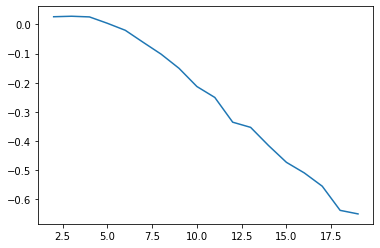

In [89]:
plt.plot(max_depths, gs_tree.cv_results_['mean_test_score'])

In [90]:
gs_tree.best_params_

{'max_depth': 3}

In [91]:
pred_tree = gs_tree.predict(X_test)
mae(y_test, pred_tree)

19.540067353835155

## Gradient Boosting Regressor

In [94]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)
max_depths = range(1,5)
param_grid = {'max_depth' : max_depths,
              'learning_rate': [0.05, .1]}
gs_gbr = GridSearchCV(gbr, param_grid=param_grid, cv=5)
gs_gbr.fit(X_train, y_train)
pred_gbr = gs_gbr.predict(X_test)
mae(y_test, pred_gbr)

19.206657427077857

In [98]:
gs_gbr.best_params_

{'learning_rate': 0.05, 'max_depth': 4}

In [113]:
gbr1 = GradientBoostingRegressor(random_state=0, max_depth=4, learning_rate=0.05)
gbr1.fit(X_train, y_train)
gbr1.feature_importances_

array([0.12710667, 0.06917791, 0.14758596, 0.08110273, 0.11335376,
       0.06336407, 0.04229667, 0.04947484, 0.05299743, 0.03051443,
       0.06416358, 0.04674623, 0.05865176, 0.05346394])

In [125]:
s = gbr1.feature_importances_.tolist()

In [116]:
s_sort = sorted(s)
s_sort

[0.030514434492973964,
 0.04229667345881277,
 0.04674623057064526,
 0.049474842396022095,
 0.05299743468016675,
 0.05346393624695358,
 0.0586517632053794,
 0.06336406881725914,
 0.06416357883187818,
 0.06917791260241818,
 0.08110272651090486,
 0.11335376385603291,
 0.12710667371352333,
 0.14758596061702972]

In [127]:
s.index(s_sort[0])

9

In [128]:
fi = []
for i in range(14):
    fi.append(s.index(s_sort[i]))

In [129]:
fi

[9, 6, 11, 7, 8, 13, 12, 5, 10, 1, 3, 4, 0, 2]

In [ ]:
fi = []
for i in :
    gbr1.feature_importances_[i]

## Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor().fit(X_train, y_train)
pred_rf = rf.predict(X_test)
mae(y_test, pred_rf)

19.75914158792294

## XGBoost

In [83]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 20, 50],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        #n_jobs = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.4min finished


0.04918227752623727
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [84]:
pred_xgb = xgb_grid.predict(X_test)
mae(y_test, pred_xgb)

19.139076

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
